In [1]:
%load_ext autoreload
%autoreload 2

import autograd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
from autograd import grad, value_and_grad

import legume
from legume.backend import backend as bd
from legume.optimizers import adam_optimize
from legume.utils import grad_num
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set some global options and parameters

options = {'gmode_inds': np.array([0, 3]),
           'gmode_compute': 'exact',
           'numeig': 10,
           'verbose': False}

lattice = legume.Lattice('square')
path = lattice.bz_path(['X', 'G', 'M'], [20, 20])

eps_b = 12
gmax = 5

In [3]:
def summarize_results(gme):
    """Summarize the results of a gme run.

    Plots the bands and the real space structure
    """
    fig, ax = plt.subplots(1)
    legume.viz.bands(gme, ax=ax, Q=True, Q_cmap='cool')
    legume.viz.structure(gme)

In [4]:
# Function to make a single-layer phc with thickness d and hole radius r
def make_reg(d=0.5, r=0.3):
    """Create the gme object and build the phc with slab thickness d and hole radius r
    """
    phc = legume.PhotCryst(lattice)
    phc.add_layer(d=d, eps_b=eps_b)
    phc.add_shape(legume.Circle(eps=1, r=r))
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    return gme

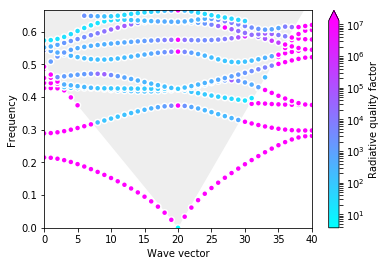

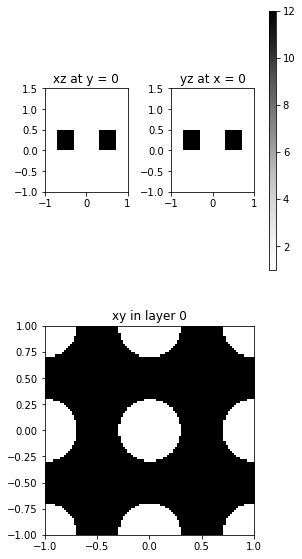

In [5]:
# Test it out
legume.set_backend('numpy')
(d0, r0) = (0.5, 0.3)
gme = make_reg(d0, r0)
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)

In [6]:
# We'll try to force a BIC at a specific k-point in the second band
kind_opt = 15
mind_opt = 1
print("Starting Q: ", gme.freqs[kind_opt, mind_opt]/2/gme.freqs_im[kind_opt, mind_opt])

Starting Q:  246.7261127976361


In [7]:
# Define objective funciton 
def objective(params):
    d = params[0]
    r = params[1]
    gme = make_reg(d, r=r)
    gme.run(kpoints=path.kpoints[:, kind_opt].reshape(2, 1), compute_im=False, **options)

    (freq_im, _, _) = gme.compute_rad(kind=0, minds=[mind_opt])

    # We define the of to be the log of the Q so that it doesn't vary too wildly
    return autograd.numpy.log10(gme.freqs[0, mind_opt]/2/freq_im)
obj_grad = value_and_grad(objective)

In [8]:
# Check gradient vs. numerical computation
legume.set_backend('autograd')
val, gr = obj_grad(np.array([d0, r0]))
print(gr)
print(grad_num(objective, np.array([d0, r0])))

[ 0.54830288 -2.0080178 ]
[ 0.54830305 -2.00801705]


In [ ]:
# options['gradients'] = 'approx' # Uncomment this to make the optimization faster using approximate gradients

# Run an optimization. We put a lower bound on the radii of 0.2 because otherwise the optimization will just
# try to make a homogeneous slab.

# The optimization is pretty unstable when it gets to very high Q. Maybe an even smaller step size is needed,
# or maybe it's just the fact that the gradient is approximate that becomes important
legume.set_backend('autograd')
t = time.time()
(p_opt, ofs) = adam_optimize(obj_grad, np.array([d0, r0]), jac=True, step_size=0.001, Nsteps=200,
                               options={'direction': 'max', 'disp': ['of', 'params']}, bounds=[0.2, 2])
print("Total time: ", time.time()-t)

legume.set_backend('numpy')
gme = make_reg(p_opt[0], p_opt[1])
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)

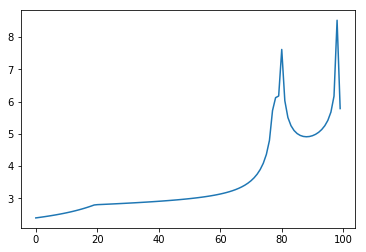

In [47]:
# Plot objective function evolution
plt.plot(ofs)
plt.show()

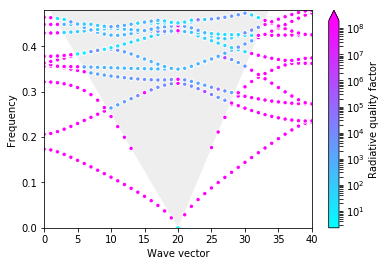

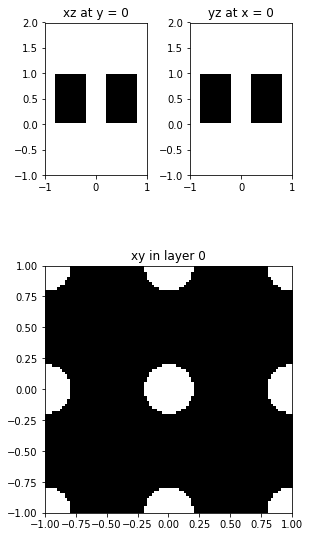

In [45]:
# Plot the best structure that was reached at the course of the optimization
# Beautiful BIC right where we wanted it!
p_max = [0.9969,  0.2010]
gme = make_reg(p_max[0], p_max[1])
gme.run(kpoints=path.kpoints, **options)
summarize_results(gme)